In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152, InceptionV3, DenseNet121, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import time

sns.set_style('whitegrid')

In [3]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [4]:
import sys
import pandas.core.indexes as indexes
sys.modules['pandas.indexes'] = indexes
sys.modules['pandas.indexes.base'] = indexes.base
sys.modules['pandas.indexes.range'] = indexes.range

data_path = '/kaggle/input/wm811k-wafer-map/LSWMD.pkl'

with open(data_path, 'rb') as f:
    df = pickle.load(f, encoding='latin1')

print(f"Dataset loaded: {len(df):,} samples")
print(f"Columns: {list(df.columns)}")

Dataset loaded: 811,457 samples
Columns: ['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel', 'failureType']


In [5]:
df_clean = df[(df['waferMap'].notna()) & 
              (df['failureType'].notna()) & 
              (df['failureType'] != 'none')]
labels_raw = []
for ft in df_clean['failureType']:
    if isinstance(ft, np.ndarray):
        labels_raw.append(str(ft[0]) if len(ft) > 0 else 'unknown')
    else:
        labels_raw.append(str(ft))

df_clean['failureType_str'] = labels_raw

print(f"Clean samples: {len(df_clean):,}")
print("\nClass Distribution:")
print(pd.Series(labels_raw).value_counts())

Clean samples: 25,519

Class Distribution:
['Edge-Ring']    9680
['Edge-Loc']     5189
['Center']       4294
['Loc']          3593
['Scratch']      1193
['Random']        866
['Donut']         555
['Near-full']     149
Name: count, dtype: int64


In [6]:
wafer_maps = list(df_clean['waferMap'])
labels = df_clean['failureType_str'].values

le = LabelEncoder()
y_encoded = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    wafer_maps, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

num_classes = len(le.classes_)
print(f"Training: {len(X_train):,} | Test: {len(X_test):,}")
print(f"Classes: {num_classes}")
print(f"Label mapping: {dict(enumerate(le.classes_))}")

Training: 20,415 | Test: 5,104
Classes: 8
Label mapping: {0: "['Center']", 1: "['Donut']", 2: "['Edge-Loc']", 3: "['Edge-Ring']", 4: "['Loc']", 5: "['Near-full']", 6: "['Random']", 7: "['Scratch']"}


In [7]:
from tensorflow.keras.utils import Sequence

class WaferDataGenerator(Sequence):

    def __init__(self, wafer_maps, labels, num_classes, batch_size=16, shuffle=True):
        self.wafer_maps = wafer_maps
        self.labels = np.asarray(labels).astype(int).ravel()  # ✅ force clean labels
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.wafer_maps))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.wafer_maps) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        X_batch = []
        for i in batch_indices:
            arr = np.array(self.wafer_maps[i], dtype=np.float32)
    
            if np.random.rand() < 0.5:
                arr = np.fliplr(arr)
            if np.random.rand() < 0.5:
                arr = np.flipud(arr)
    
            if arr.max() > 0:
                arr = arr / arr.max()
    
            arr_resized = cv2.resize(arr, (224, 224))
            arr_rgb = np.stack([arr_resized] * 3, axis=-1)
            arr_rgb = preprocess_input(arr_rgb * 255.0)
    
            X_batch.append(arr_rgb)
    
        X_batch = np.array(X_batch, dtype=np.float32)
        y_batch = np.array(self.labels[batch_indices], dtype=np.int32)
    
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

y_train = np.asarray(y_train).astype(int).ravel()
y_test  = np.asarray(y_test).astype(int).ravel()

train_gen = WaferDataGenerator(X_train, y_train, num_classes=num_classes, batch_size=16, shuffle=True)
test_gen  = WaferDataGenerator(X_test, y_test,  num_classes=num_classes, batch_size=16, shuffle=False)

print(f"Train generator: {len(train_gen)} batches")
print(f"Test generator: {len(test_gen)} batches")

Train generator: 1276 batches
Test generator: 319 batches


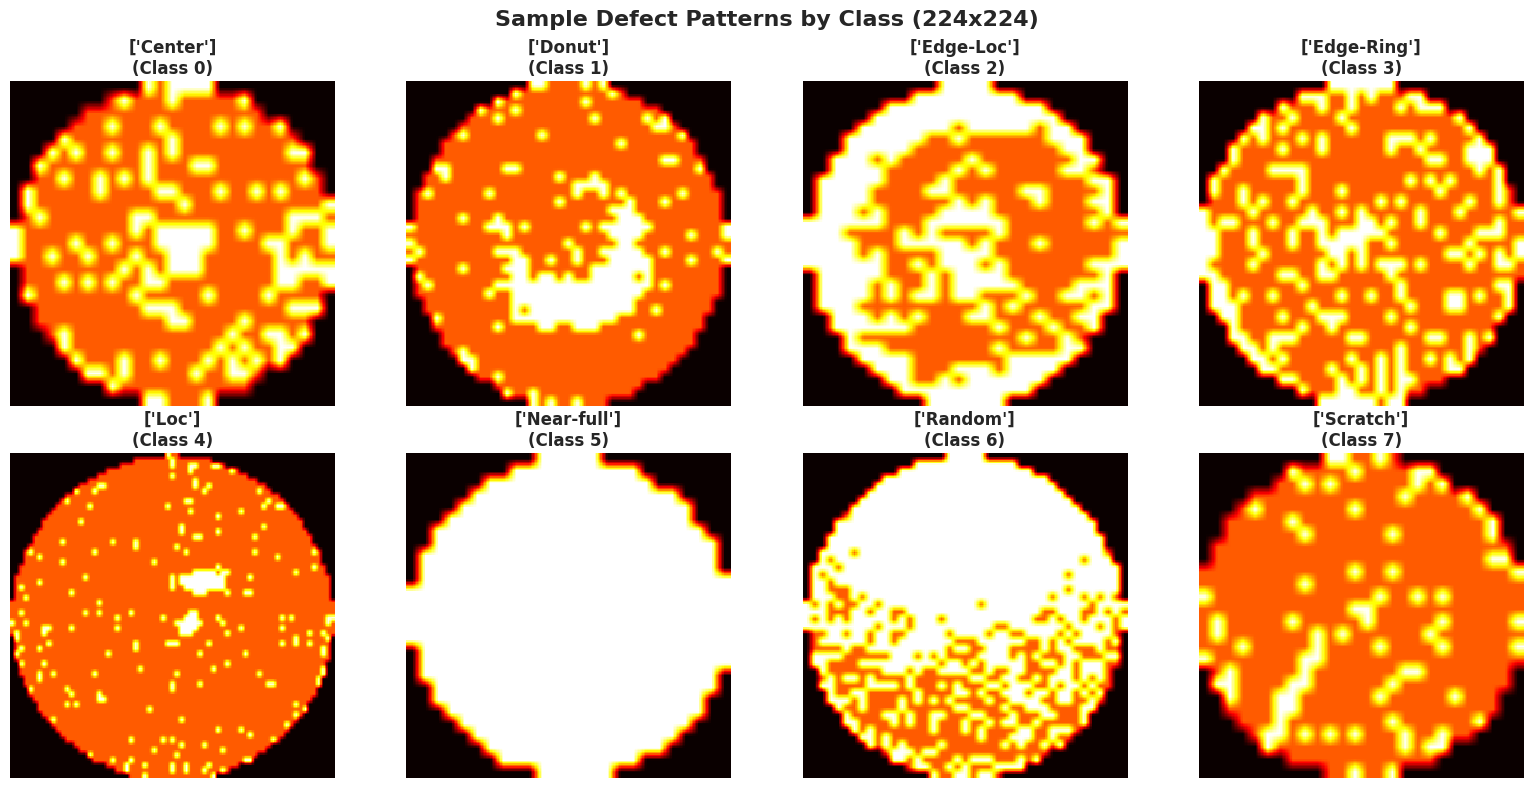

In [8]:
def preprocess_single(wafer_map):
    arr = np.array(wafer_map, dtype=np.float32)
    if arr.max() > 0:
        arr = arr / arr.max()
    arr_resized = cv2.resize(arr, (224, 224))
    return arr_resized

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, class_name in enumerate(le.classes_):
    class_idx = np.where(y_train == i)[0][0]
    sample = preprocess_single(X_train[class_idx])
    
    axes[i].imshow(sample, cmap='hot', interpolation='nearest')
    axes[i].set_title(f'{class_name}\n(Class {i})', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Defect Patterns by Class (224x224)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

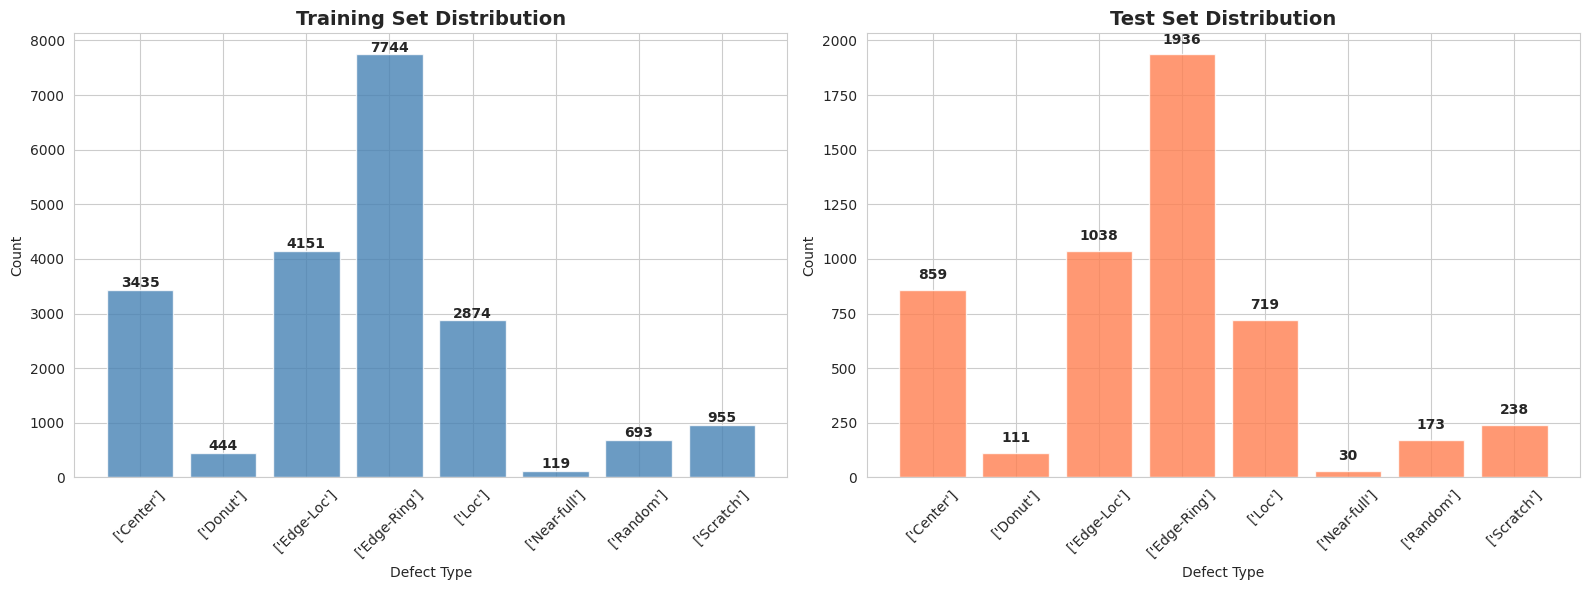

Class distribution analyzed!

Class Balance Ratio (Train): 0.015
Class Balance Ratio (Test): 0.015


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

train_counts = pd.Series(y_train).value_counts().sort_index()
train_labels = [le.classes_[i] for i in train_counts.index]
ax1.bar(train_labels, train_counts.values, color='steelblue', alpha=0.8)
ax1.set_title('Training Set Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Defect Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(train_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', fontweight='bold')

test_counts = pd.Series(y_test).value_counts().sort_index()
test_labels = [le.classes_[i] for i in test_counts.index]
ax2.bar(test_labels, test_counts.values, color='coral', alpha=0.8)
ax2.set_title('Test Set Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Defect Type')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(test_counts.values):
    ax2.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Class distribution analyzed!")
print(f"\nClass Balance Ratio (Train): {train_counts.min() / train_counts.max():.3f}")
print(f"Class Balance Ratio (Test): {test_counts.min() / test_counts.max():.3f}")

PCA explained variance: 61.36%


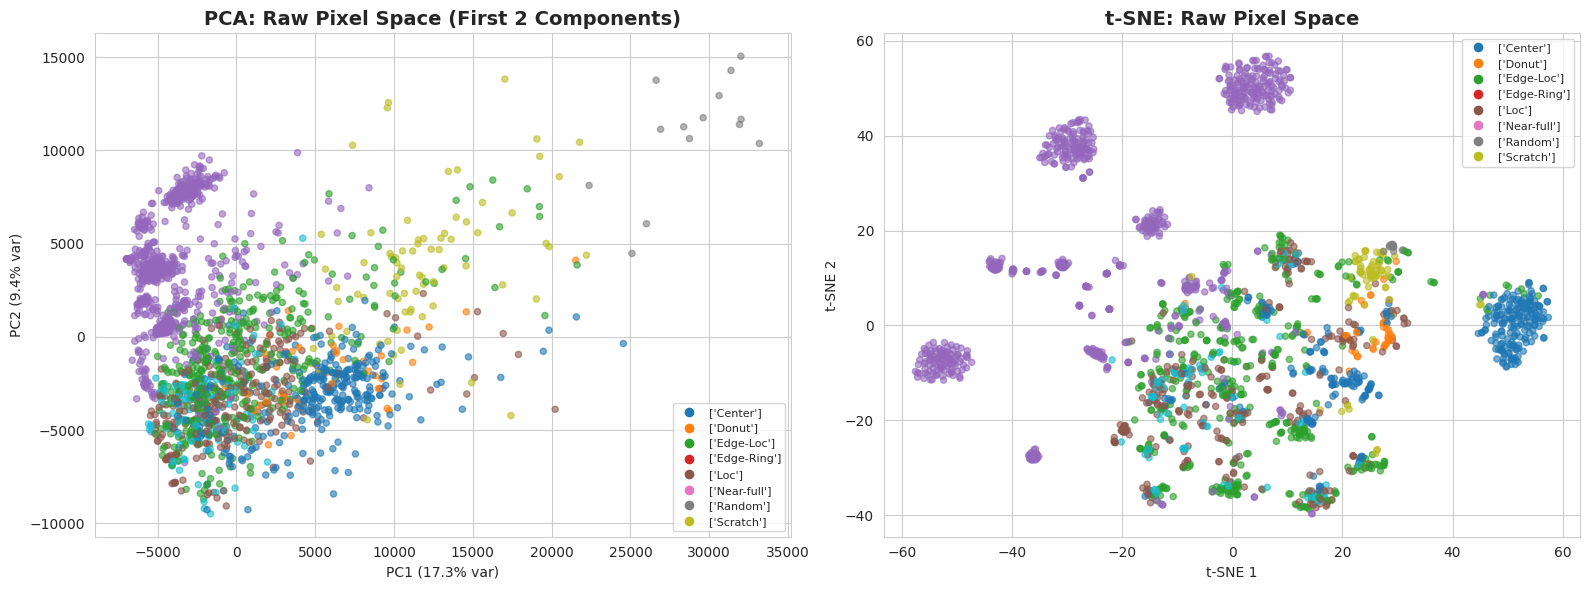

In [10]:
X_subset_flat = []
for i in range(min(2000, len(X_train))):
    arr = np.array(X_train[i], dtype=np.float32)
    if arr.max() > 0:
        arr = arr / arr.max()
    arr_resized = cv2.resize(arr, (224, 224))
    arr_rgb = np.stack([arr_resized] * 3, axis=-1)
    arr_rgb = preprocess_input(arr_rgb * 255.0)

    X_subset_flat.append(arr_rgb.flatten())

X_subset_flat = np.array(X_subset_flat)
y_train_subset = y_train[:len(X_subset_flat)]

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_subset_flat)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], 
                       c=y_train_subset, cmap='tab10', 
                       alpha=0.6, s=20)
ax1.set_title('PCA: Raw Pixel Space (First 2 Components)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')

legend_elements_1 = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=plt.cm.tab10(i/num_classes), 
                                markersize=8, label=le.classes_[i]) 
                     for i in range(num_classes)]
ax1.legend(handles=legend_elements_1, loc='best', fontsize=8)

scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                       c=y_train_subset, cmap='tab10', 
                       alpha=0.6, s=20)
ax2.set_title('t-SNE: Raw Pixel Space', fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

legend_elements_2 = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=plt.cm.tab10(i/num_classes), 
                                markersize=8, label=le.classes_[i]) 
                     for i in range(num_classes)]
ax2.legend(handles=legend_elements_2, loc='best', fontsize=8)

plt.tight_layout()
plt.show()

**section 3 hai**

In [11]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=8):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

custom_cnn = build_custom_cnn(num_classes=num_classes)
custom_cnn.summary()

I0000 00:00:1766803293.849323     577 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766803293.849899     577 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,444,136 (5.51 MB)

 Trainable params: 1,440,680 (5.50 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [12]:
def build_resnet152(input_shape=(224, 224, 3), num_classes=8):
    base_model = ResNet152(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

resnet_model = build_resnet152(num_classes=num_classes)
print(f"ResNet152 built")
print(f"Total params: {resnet_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in resnet_model.trainable_weights]):,}")

ResNet152 built
Total params: 59,426,184
Trainable params: 59,273,736


In [13]:
def build_inceptionv3(input_shape=(224, 224, 3), num_classes=8):
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
inception_model = build_inceptionv3(num_classes=num_classes)
print(f"InceptionV3 built!")
print(f"Total params: {inception_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in inception_model.trainable_weights]):,}")

InceptionV3 built!
Total params: 22,858,024
Trainable params: 22,822,568


In [14]:
def build_densenet121(input_shape=(224, 224, 3), num_classes=8):
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

densenet_model = build_densenet121(num_classes=num_classes)
print(f"DenseNet121 built")
print(f"Total params: {densenet_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in densenet_model.trainable_weights]):,}")

DenseNet121 built
Total params: 7,568,456
Trainable params: 7,483,784


In [15]:
def build_mobilenetv2(input_shape=(224, 224, 3), num_classes=8):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

mobilenet_model = build_mobilenetv2(num_classes=num_classes)
print(f"MobileNetV2 built")
print(f"Total params: {mobilenet_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in mobilenet_model.trainable_weights]):,}")

MobileNetV2 built
Total params: 2,920,008
Trainable params: 2,187,400




**imp block ---- rishi look into this --- this is like the training universal block, have included callbacks**

In [16]:
def train_model_gen(model, model_name, train_gen, test_gen, epochs=15):
    print(f"Training {model_name}")
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
    ]
    
    start_time = time.time()
    
    history = model.fit(
        train_gen,
        validation_data=test_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    print(f"\n{model_name} Complete")
    print(f"Time: {train_time/60:.2f} minutes")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    
    return history, train_time, test_acc

In [17]:
def clear_session_memory():
    keras.backend.clear_session()
    import gc
    gc.collect()
    print("Memory cleared")

print("Memory management ready!")

Memory management ready!


Training Custom CNN
Epoch 1/15


I0000 00:00:1766803310.111794     624 service.cc:148] XLA service 0x7f9398005090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766803310.111832     624 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766803310.111836     624 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766803310.966189     624 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1276 ━━━━━━━━━━━━━━━━━━━━ 7:01:03 20s/step - accuracy: 0.1250 - loss: 3.2878

I0000 00:00:1766803323.774345     624 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1276/1276 ━━━━━━━━━━━━━━━━━━━━ 156s 107ms/step - accuracy: 0.5887 - loss: 1.3112 - val_accuracy: 0.6099 - val_loss: 1.2624 - learning_rate: 0.0010
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 119s 93ms/step - accuracy: 0.7184 - loss: 0.7350 - val_accuracy: 0.5221 - val_loss: 2.4914 - learning_rate: 0.0010
Epoch 3/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 118s 93ms/step - accuracy: 0.7686 - loss: 0.5959 - val_accuracy: 0.7543 - val_loss: 0.8184 - learning_rate: 0.0010
Epoch 4/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 118s 93ms/step - accuracy: 0.8085 - loss: 0.5003 - val_accuracy: 0.5858 - val_loss: 1.2889 - learning_rate: 0.0010
Epoch 5/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 118s 93ms/step - accuracy: 0.8367 - loss: 0.4502 - val_accuracy: 0.8333 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 6/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 118s 92ms/step - accuracy: 0.8503 - loss: 0.4097 - val_accuracy: 0.8100 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 7/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 118s 92ms/step - accuracy:

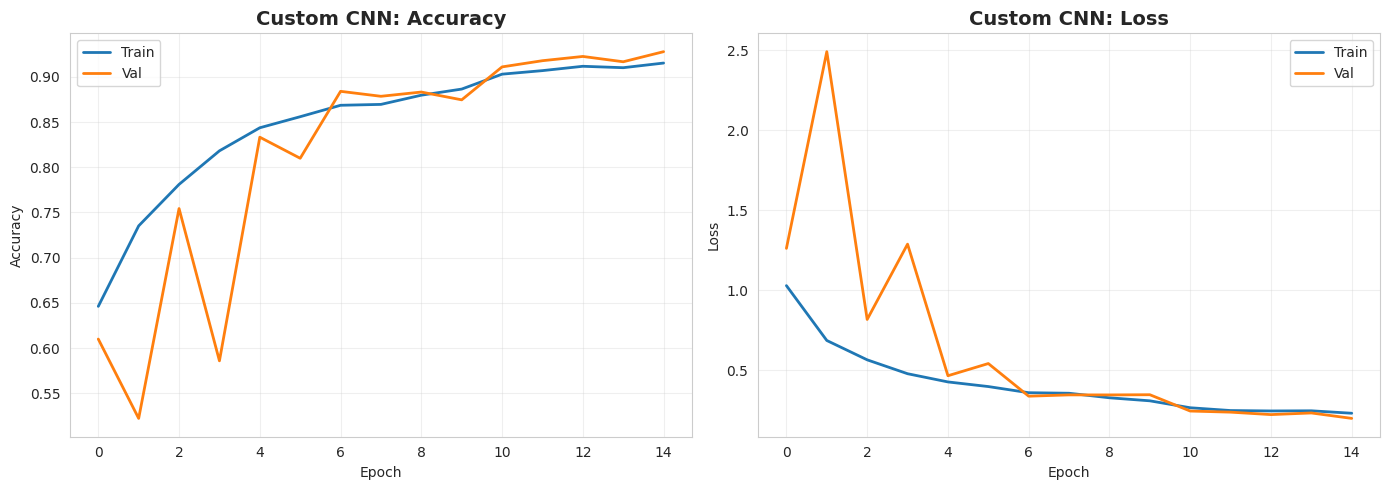

Custom CNN training complete


In [18]:
keras.backend.clear_session()
import gc
gc.collect()

model_custom = build_custom_cnn(num_classes=num_classes)

history_custom, time_custom, acc_custom = train_model_gen(
    model=model_custom,
    model_name="Custom CNN",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_custom.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history_custom.history['val_accuracy'], label='Val', linewidth=2)
ax1.set_title('Custom CNN: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_custom.history['loss'], label='Train', linewidth=2)
ax2.plot(history_custom.history['val_loss'], label='Val', linewidth=2)
ax2.set_title('Custom CNN: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Custom CNN training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 257s 180ms/step - accuracy: 0.7023 - loss: 0.8607 - val_accuracy: 0.8266 - val_loss: 0.4367
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 211s 166ms/step - accuracy: 0.7989 - loss: 0.5318 - val_accuracy: 0.8194 - val_loss: 0.4607
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 212s 166ms/step - accuracy: 0.8162 - loss: 0.4897 - val_accuracy: 0.7994 - val_loss: 0.4800
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 212s 166ms/step - accuracy: 0.8117 - loss: 0.4932 - val_accuracy: 0.8421 - val_loss: 0.4142
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 212s 166ms/step - accuracy: 0.8165 - loss: 0.4741 - val_accuracy: 0.8403 - val_loss: 0.4011
Training ResNet152
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 859s 563ms/step - accuracy: 0.7243 - loss: 0.8126 - val_accuracy: 0.8862 - val_loss: 0.3248 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 664s 520ms/step - accuracy: 0.8824 - loss: 0.3166 - val_accuracy: 0.9032 - val_loss: 0.2729 - learning_rate: 1.0

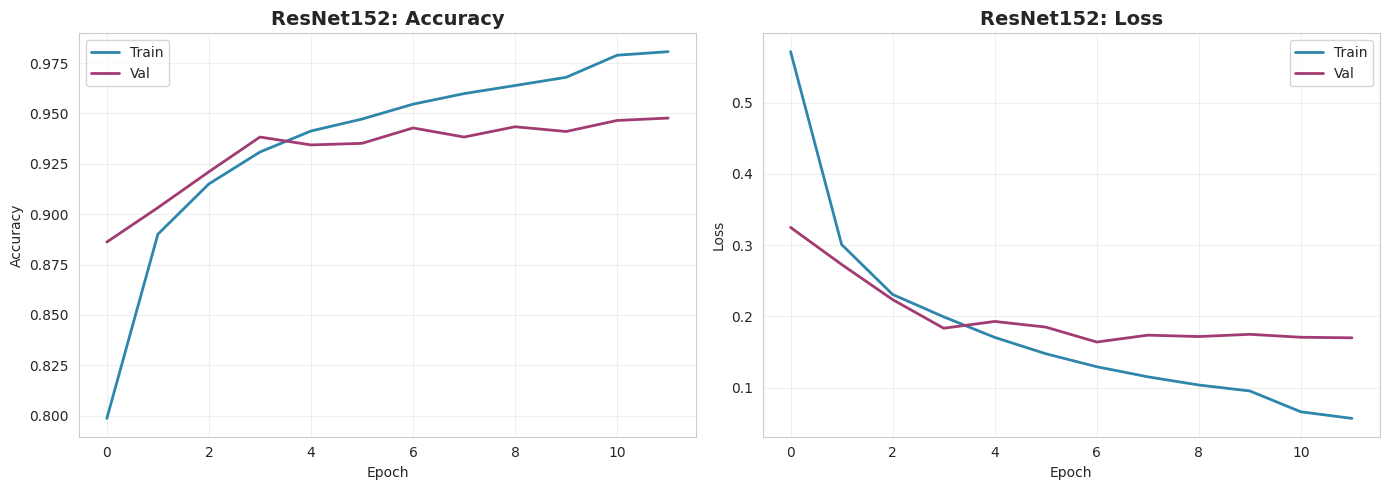

ResNet152 training complete


In [19]:
keras.backend.clear_session()
import gc
gc.collect()

model_resnet = build_resnet152(num_classes=num_classes)

model_resnet.layers[0].trainable = False
model_resnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.fit(train_gen, validation_data=test_gen, epochs=5)

model_resnet.layers[0].trainable = True
model_resnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_resnet, time_resnet, acc_resnet = train_model_gen(
    model=model_resnet,
    model_name="ResNet152",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)

print(f"Final Test Accuracy: {acc_resnet*100:.2f}%")
print(f"Training Time: {time_resnet/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_resnet.history['accuracy'], label='Train', linewidth=2, color='#2E86AB')
ax1.plot(history_resnet.history['val_accuracy'], label='Val', linewidth=2, color='#A23B72')
ax1.set_title('ResNet152: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_resnet.history['loss'], label='Train', linewidth=2, color='#2E86AB')
ax2.plot(history_resnet.history['val_loss'], label='Val', linewidth=2, color='#A23B72')
ax2.set_title('ResNet152: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ResNet152 training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 83s 56ms/step - accuracy: 0.6407 - loss: 1.0516 - val_accuracy: 0.7384 - val_loss: 0.7034
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - accuracy: 0.7138 - loss: 0.7613 - val_accuracy: 0.6718 - val_loss: 0.8317
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - accuracy: 0.7250 - loss: 0.7270 - val_accuracy: 0.7190 - val_loss: 0.7288
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - accuracy: 0.7353 - loss: 0.7165 - val_accuracy: 0.7343 - val_loss: 0.6945
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - accuracy: 0.7461 - loss: 0.6897 - val_accuracy: 0.7384 - val_loss: 0.7548
Training InceptionV3
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 282s 175ms/step - accuracy: 0.5721 - loss: 1.3162 - val_accuracy: 0.7516 - val_loss: 0.6409 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 194s 152ms/step - accuracy: 0.7393 - loss: 0.6853 - val_accuracy: 0.8221 - val_loss: 0.4708 - learning_rate: 1.0000e-05


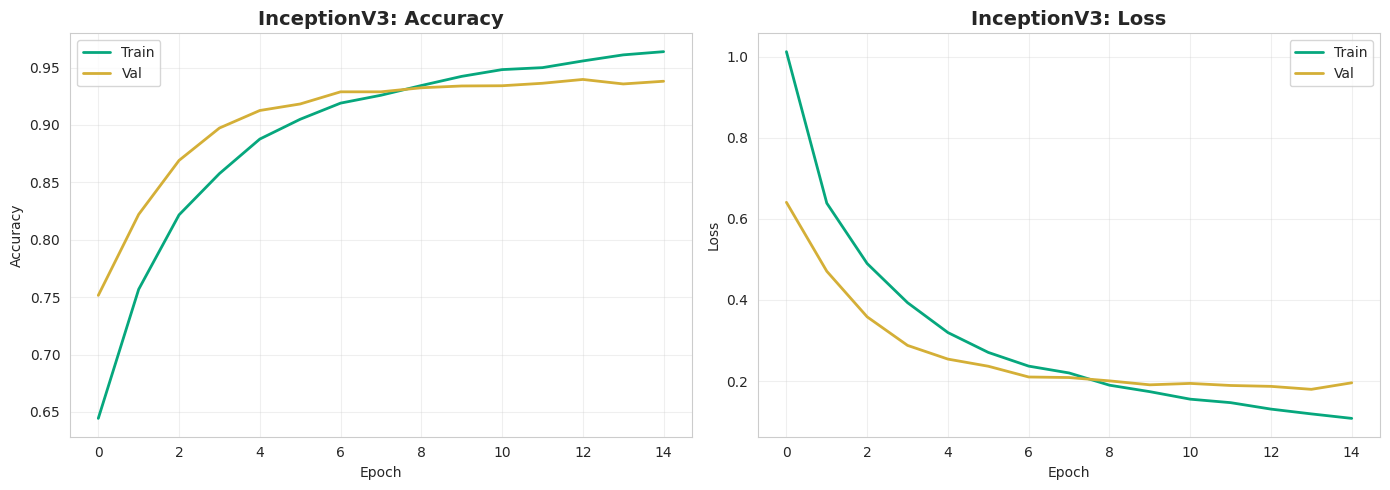

InceptionV3 training complete


In [21]:
keras.backend.clear_session()
import gc
gc.collect()

model_inception = build_inceptionv3(num_classes=num_classes)

model_inception.layers[0].trainable = False
model_inception.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_inception.fit(train_gen, validation_data=test_gen, epochs=5)

model_inception.layers[0].trainable = True
model_inception.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_inception, time_inception, acc_inception = train_model_gen(
    model=model_inception,
    model_name="InceptionV3",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)


print(f"InceptionV3 Training Summary")
print(f"Final Test Accuracy: {acc_inception*100:.2f}%")
print(f"Training Time: {time_inception/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_inception.history['accuracy'], label='Train', linewidth=2, color='#06A77D')
ax1.plot(history_inception.history['val_accuracy'], label='Val', linewidth=2, color='#D4AF37')
ax1.set_title('InceptionV3: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_inception.history['loss'], label='Train', linewidth=2, color='#06A77D')
ax2.plot(history_inception.history['val_loss'], label='Val', linewidth=2, color='#D4AF37')
ax2.set_title('InceptionV3: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("InceptionV3 training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 118s 73ms/step - accuracy: 0.6592 - loss: 0.9637 - val_accuracy: 0.7300 - val_loss: 0.7304
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.7231 - loss: 0.7072 - val_accuracy: 0.7545 - val_loss: 0.6472
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.7343 - loss: 0.6917 - val_accuracy: 0.7134 - val_loss: 0.7223
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.7484 - loss: 0.6532 - val_accuracy: 0.7220 - val_loss: 0.7152
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.7502 - loss: 0.6495 - val_accuracy: 0.6663 - val_loss: 0.7846
Training DenseNet121
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 457s 249ms/step - accuracy: 0.5861 - loss: 1.5697 - val_accuracy: 0.7249 - val_loss: 0.7340 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 228s 179ms/step - accuracy: 0.7514 - loss: 0.6847 - val_accuracy: 0.8219 - val_loss: 0.4624 - learning_rate: 1.0000e-05

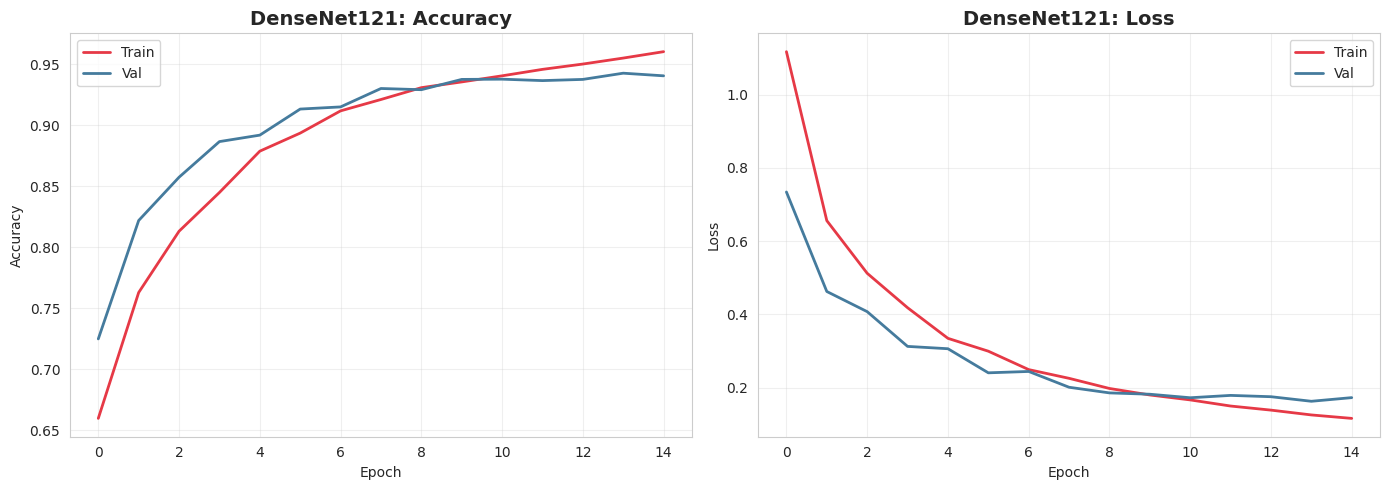

DenseNet121 training complete


In [22]:
keras.backend.clear_session()
import gc
gc.collect()

model_densenet = build_densenet121(num_classes=num_classes)

model_densenet.layers[0].trainable = False
model_densenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_densenet.fit(train_gen, validation_data=test_gen, epochs=5)

model_densenet.layers[0].trainable = True
model_densenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_densenet, time_densenet, acc_densenet = train_model_gen(
    model=model_densenet,
    model_name="DenseNet121",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)

print(f"DenseNet121 Training Summary")
print(f"Final Test Accuracy: {acc_densenet*100:.2f}%")
print(f"Training Time: {time_densenet/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_densenet.history['accuracy'], label='Train', linewidth=2, color='#E63946')
ax1.plot(history_densenet.history['val_accuracy'], label='Val', linewidth=2, color='#457B9D')
ax1.set_title('DenseNet121: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_densenet.history['loss'], label='Train', linewidth=2, color='#E63946')
ax2.plot(history_densenet.history['val_loss'], label='Val', linewidth=2, color='#457B9D')
ax2.set_title('DenseNet121: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("DenseNet121 training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.6337 - loss: 1.0474 - val_accuracy: 0.7104 - val_loss: 0.7318
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.7098 - loss: 0.7448 - val_accuracy: 0.7175 - val_loss: 0.7350
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.7287 - loss: 0.7082 - val_accuracy: 0.7349 - val_loss: 0.6795
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.7332 - loss: 0.6942 - val_accuracy: 0.7531 - val_loss: 0.6296
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.7458 - loss: 0.6634 - val_accuracy: 0.7465 - val_loss: 0.6302
Training MobileNetV2
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 144s 81ms/step - accuracy: 0.5748 - loss: 1.4029 - val_accuracy: 0.6023 - val_loss: 1.2534 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.7230 - loss: 0.7373 - val_accuracy: 0.7571 - val_loss: 0.6389 - learning_rate: 1.0000e-05
Epo

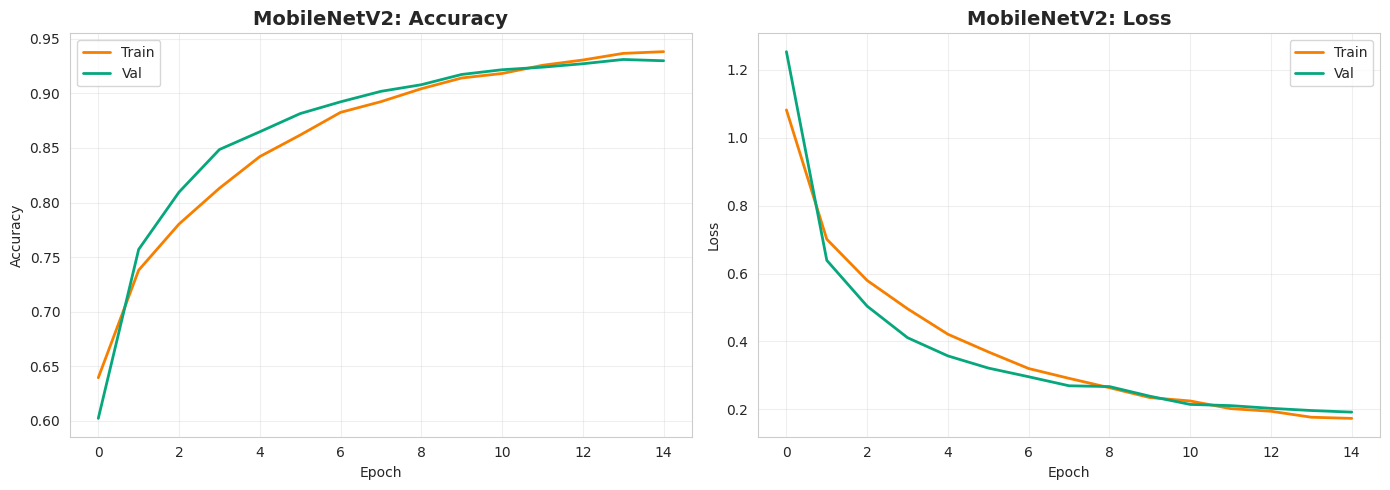

MobileNetV2 training complete


In [23]:
keras.backend.clear_session()
import gc
gc.collect()

model_mobilenet = build_mobilenetv2(num_classes=num_classes)

model_mobilenet.layers[0].trainable = False
model_mobilenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenet.fit(train_gen, validation_data=test_gen, epochs=5)

model_mobilenet.layers[0].trainable = True
model_mobilenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_mobilenet, time_mobilenet, acc_mobilenet = train_model_gen(
    model=model_mobilenet,
    model_name="MobileNetV2",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)


print(f"MobileNetV2 Training Summary")
print(f"Final Test Accuracy: {acc_mobilenet*100:.2f}%")
print(f"Training Time: {time_mobilenet/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_mobilenet.history['accuracy'], label='Train', linewidth=2, color='#F77F00')
ax1.plot(history_mobilenet.history['val_accuracy'], label='Val', linewidth=2, color='#06A77D')
ax1.set_title('MobileNetV2: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_mobilenet.history['loss'], label='Train', linewidth=2, color='#F77F00')
ax2.plot(history_mobilenet.history['val_loss'], label='Val', linewidth=2, color='#06A77D')
ax2.set_title('MobileNetV2: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("MobileNetV2 training complete")


ALL MODELS TRAINED - QUICK COMPARISON
      Model  Test Accuracy (%)  Training Time (min)
  ResNet152          94.239813           135.888166
DenseNet121          94.063479            60.721362
InceptionV3          93.750000            49.872684
MobileNetV2          93.456113            21.601123
 Custom CNN          92.535269            30.117908


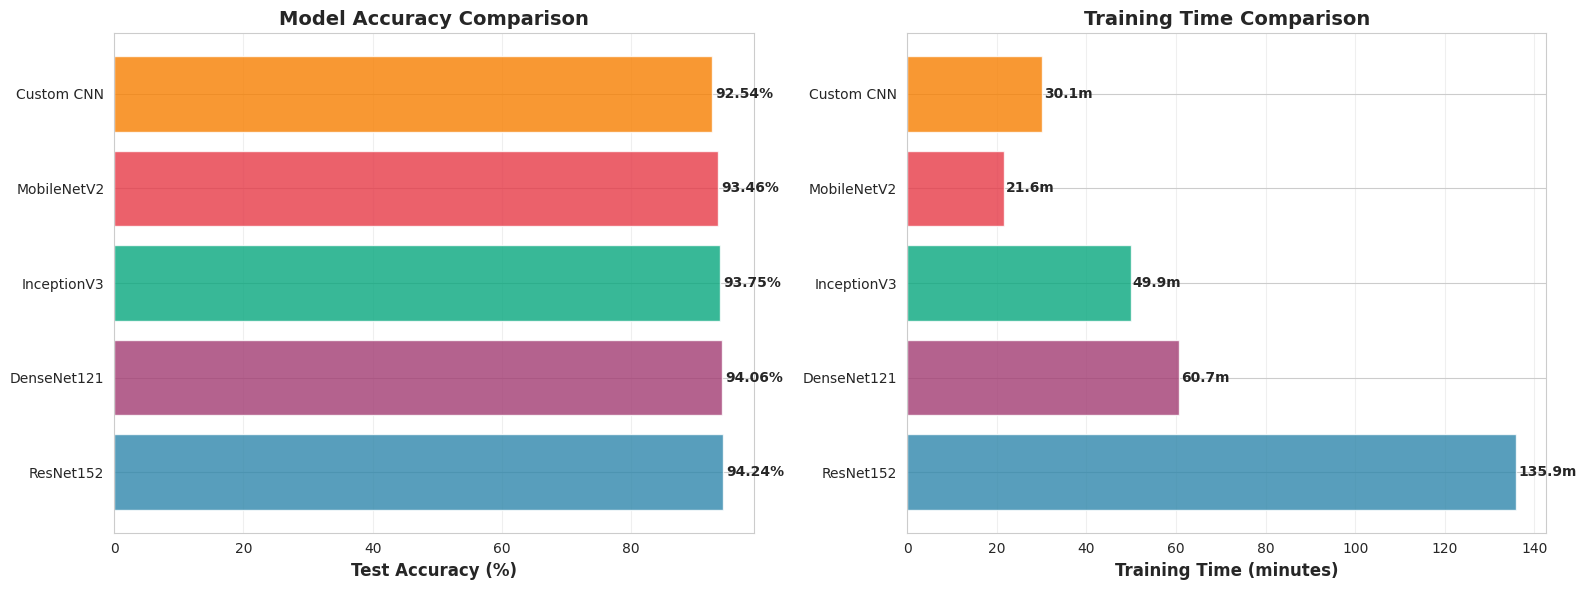

In [24]:
results_summary = {
    'Model': ['Custom CNN', 'ResNet152', 'InceptionV3', 'DenseNet121', 'MobileNetV2'],
    'Test Accuracy (%)': [
        acc_custom * 100,
        acc_resnet * 100,
        acc_inception * 100,
        acc_densenet * 100,
        acc_mobilenet * 100
    ],
    'Training Time (min)': [
        time_custom / 60,
        time_resnet / 60,
        time_inception / 60,
        time_densenet / 60,
        time_mobilenet / 60
    ]
}

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Test Accuracy (%)', ascending=False)

print("\n" + "="*70)
print("ALL MODELS TRAINED - QUICK COMPARISON")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#2E86AB', '#A23B72', '#06A77D', '#E63946', '#F77F00']
ax1.barh(results_df['Model'], results_df['Test Accuracy (%)'], color=colors, alpha=0.8)
ax1.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['Test Accuracy (%)']):
    ax1.text(v + 0.5, i, f'{v:.2f}%', va='center', fontweight='bold')

ax2.barh(results_df['Model'], results_df['Training Time (min)'], color=colors, alpha=0.8)
ax2.set_xlabel('Training Time (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['Training Time (min)']):
    ax2.text(v + 0.5, i, f'{v:.1f}m', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Custom CNN - Classification Report
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step
               precision    recall  f1-score   support

   ['Center']       0.92      0.95      0.93       859
    ['Donut']       0.72      0.87      0.79       111
 ['Edge-Loc']       0.94      0.89      0.91      1038
['Edge-Ring']       0.98      0.99      0.98      1936
      ['Loc']       0.82      0.80      0.81       719
['Near-full']       0.87      0.87      0.87        30
   ['Random']       0.91      0.91      0.91       173
  ['Scratch']       0.86      0.89      0.87       238

     accuracy                           0.92      5104
    macro avg       0.88      0.90      0.89      5104
 weighted avg       0.92      0.92      0.92      5104



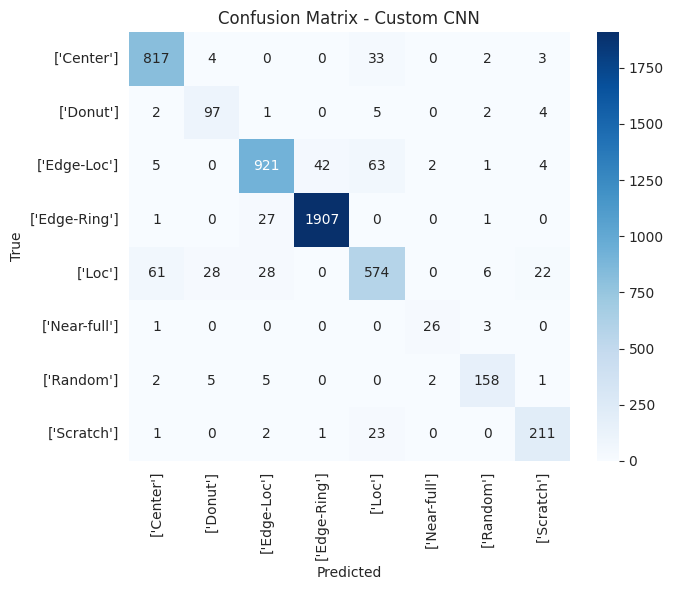

ResNet152 - Classification Report
319/319 ━━━━━━━━━━━━━━━━━━━━ 51s 134ms/step
               precision    recall  f1-score   support

   ['Center']       0.97      0.97      0.97       859
    ['Donut']       0.86      0.91      0.88       111
 ['Edge-Loc']       0.93      0.91      0.92      1038
['Edge-Ring']       0.98      0.99      0.99      1936
      ['Loc']       0.87      0.87      0.87       719
['Near-full']       0.69      0.90      0.78        30
   ['Random']       0.92      0.88      0.90       173
  ['Scratch']       0.90      0.92      0.91       238

     accuracy                           0.94      5104
    macro avg       0.89      0.92      0.90      5104
 weighted avg       0.94      0.94      0.94      5104



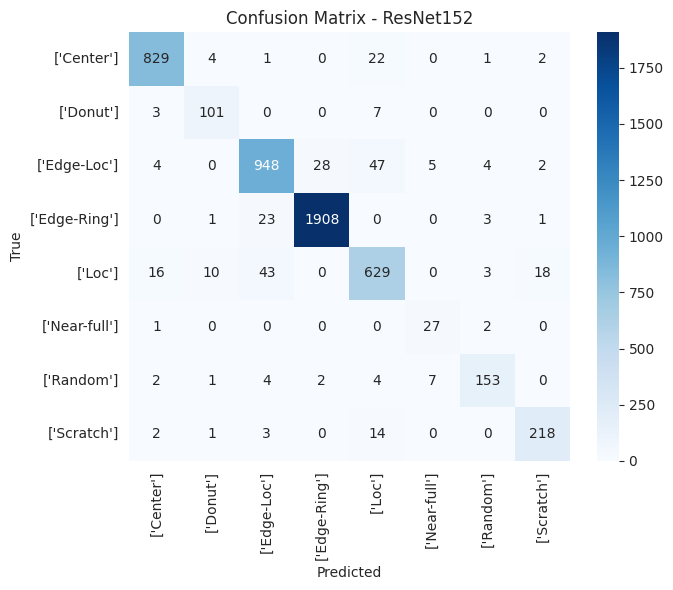

InceptionV3 - Classification Report
319/319 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step
               precision    recall  f1-score   support

   ['Center']       0.95      0.98      0.96       859
    ['Donut']       0.84      0.90      0.87       111
 ['Edge-Loc']       0.89      0.94      0.91      1038
['Edge-Ring']       0.98      0.99      0.99      1936
      ['Loc']       0.92      0.80      0.85       719
['Near-full']       0.82      0.93      0.87        30
   ['Random']       0.93      0.88      0.90       173
  ['Scratch']       0.89      0.92      0.90       238

     accuracy                           0.94      5104
    macro avg       0.90      0.92      0.91      5104
 weighted avg       0.94      0.94      0.94      5104



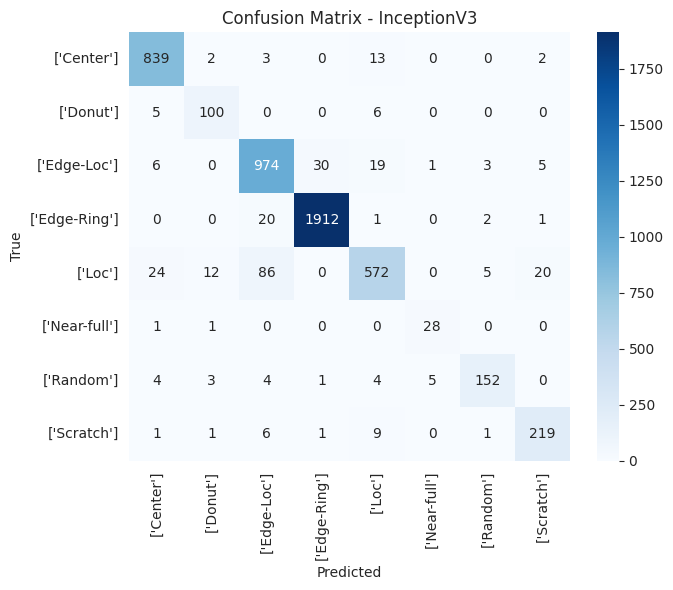

DenseNet121 - Classification Report
319/319 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step
               precision    recall  f1-score   support

   ['Center']       0.97      0.95      0.96       859
    ['Donut']       0.88      0.84      0.86       111
 ['Edge-Loc']       0.90      0.94      0.92      1038
['Edge-Ring']       0.98      0.99      0.99      1936
      ['Loc']       0.89      0.85      0.87       719
['Near-full']       0.90      0.90      0.90        30
   ['Random']       0.89      0.94      0.91       173
  ['Scratch']       0.93      0.89      0.91       238

     accuracy                           0.94      5104
    macro avg       0.92      0.91      0.91      5104
 weighted avg       0.94      0.94      0.94      5104



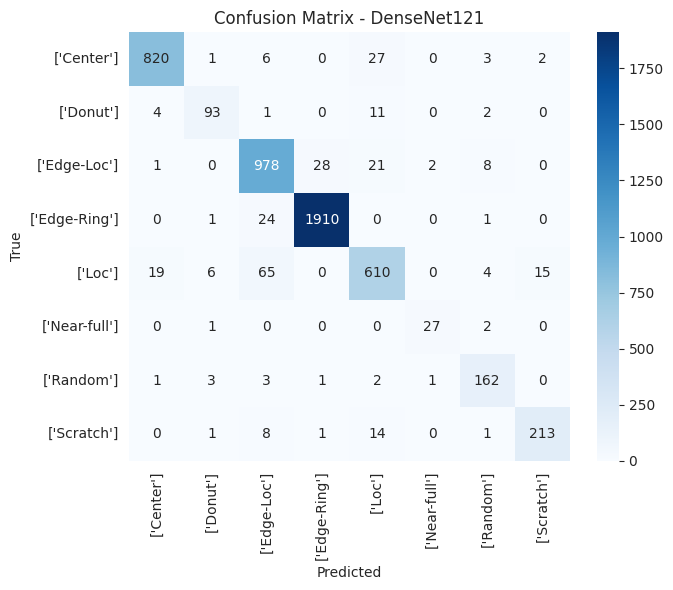

MobileNetV2 - Classification Report
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
               precision    recall  f1-score   support

   ['Center']       0.93      0.98      0.95       859
    ['Donut']       0.84      0.88      0.86       111
 ['Edge-Loc']       0.89      0.92      0.90      1038
['Edge-Ring']       0.99      0.97      0.98      1936
      ['Loc']       0.87      0.82      0.85       719
['Near-full']       0.87      0.90      0.89        30
   ['Random']       0.89      0.92      0.90       173
  ['Scratch']       0.92      0.88      0.90       238

     accuracy                           0.93      5104
    macro avg       0.90      0.91      0.90      5104
 weighted avg       0.93      0.93      0.93      5104



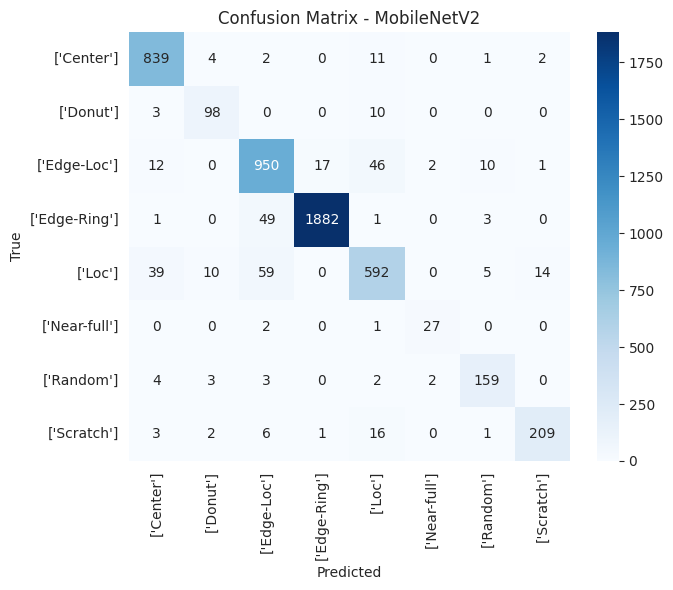

In [25]:
models_dict = {
    "Custom CNN": model_custom,
    "ResNet152": model_resnet,
    "InceptionV3": model_inception,
    "DenseNet121": model_densenet,
    "MobileNetV2": model_mobilenet
}

def evaluate_model(model, name, test_gen):
    print(f"{name} - Classification Report")
    y_true = test_gen.labels[:len(test_gen.indices)]

    y_prob = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    print(classification_report(y_true, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return y_true, y_pred


results_preds = {}

for name, model in models_dict.items():
    y_t, y_p = evaluate_model(model, name, test_gen)
    results_preds[name] = (y_t, y_p)

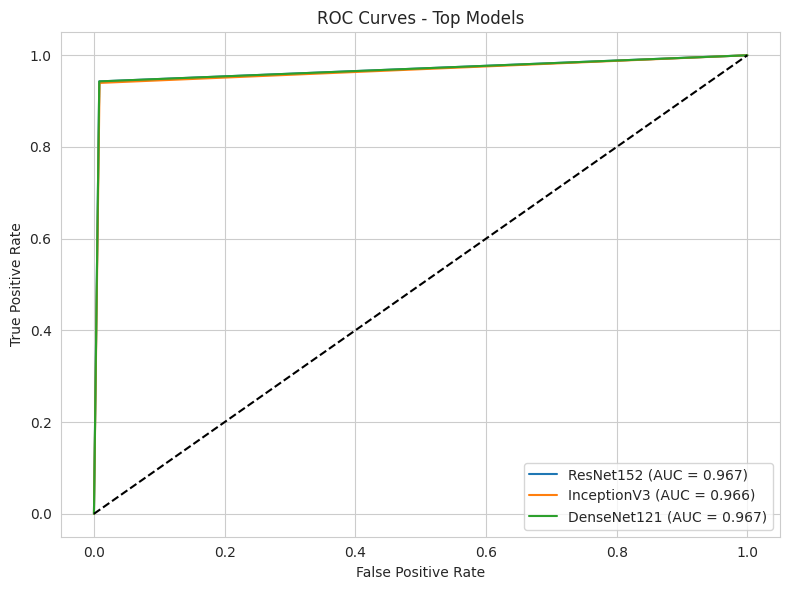

In [26]:
plt.figure(figsize=(8,6))

for name in ["ResNet152", "InceptionV3", "DenseNet121"]:
    y_true, y_pred = results_preds[name]
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    y_pred_bin = label_binarize(y_pred, classes=range(num_classes))

    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Top Models")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_model_final(model, name, test_gen):
    print(f"\n{'='*60}")
    print(f"{name} - Final Evaluation")
    print(f"{'='*60}")

    y_true, y_pred, y_prob = [], [], []

    for X_batch, y_batch in test_gen:
        probs = model.predict(X_batch, verbose=0)
        preds = np.argmax(probs, axis=1)

        y_true.extend(y_batch)
        y_pred.extend(preds)
        y_prob.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    print(classification_report(
        y_true, y_pred,
        target_names=le.classes_,
        digits=4
    ))

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Macro F1:    {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f"Normalized Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return y_true, y_pred, y_prob, macro_f1, weighted_f1

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_model_final(model, name, test_gen):
    print(f"\n{'='*60}")
    print(f"{name} - Final Evaluation")
    print(f"{'='*60}")

    y_prob = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    y_true = test_gen.labels[:len(y_pred)]

    print(classification_report(
        y_true, y_pred,
        target_names=le.classes_,
        digits=4
    ))

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Macro F1:    {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f"Normalized Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return y_true, y_pred, y_prob, macro_f1, weighted_f1


Custom CNN - Final Evaluation
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
               precision    recall  f1-score   support

   ['Center']     0.9167    0.9476    0.9319       859
    ['Donut']     0.7313    0.8829    0.8000       111
 ['Edge-Loc']     0.9418    0.8882    0.9142      1038
['Edge-Ring']     0.9774    0.9850    0.9812      1936
      ['Loc']     0.8321    0.7997    0.8156       719
['Near-full']     0.8966    0.8667    0.8814        30
   ['Random']     0.8994    0.9306    0.9148       173
  ['Scratch']     0.8577    0.9118    0.8839       238

     accuracy                         0.9248      5104
    macro avg     0.8816    0.9016    0.8904      5104
 weighted avg     0.9254    0.9248    0.9246      5104

Macro F1:    0.8904
Weighted F1: 0.9246


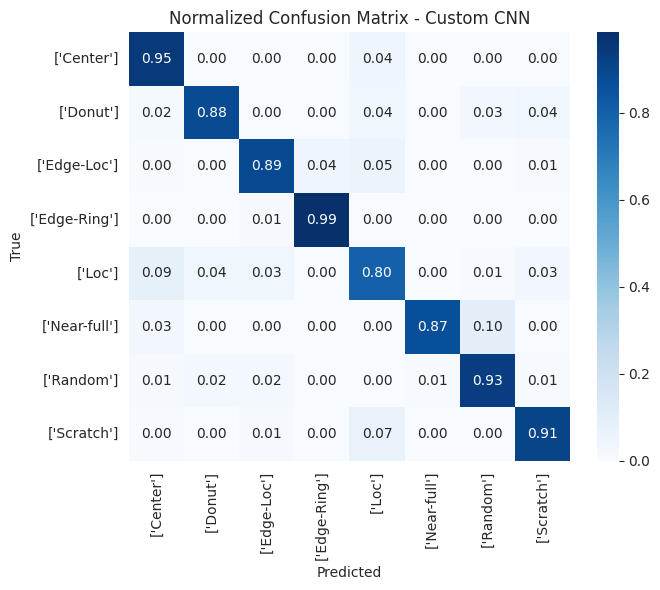


ResNet152 - Final Evaluation
319/319 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step
               precision    recall  f1-score   support

   ['Center']     0.9626    0.9593    0.9609       859
    ['Donut']     0.8655    0.9279    0.8957       111
 ['Edge-Loc']     0.9184    0.9104    0.9144      1038
['Edge-Ring']     0.9866    0.9866    0.9866      1936
      ['Loc']     0.8548    0.8679    0.8613       719
['Near-full']     0.7000    0.9333    0.8000        30
   ['Random']     0.9512    0.9017    0.9258       173
  ['Scratch']     0.9130    0.8824    0.8974       238

     accuracy                         0.9404      5104
    macro avg     0.8940    0.9212    0.9053      5104
 weighted avg     0.9412    0.9404    0.9406      5104

Macro F1:    0.9053
Weighted F1: 0.9406


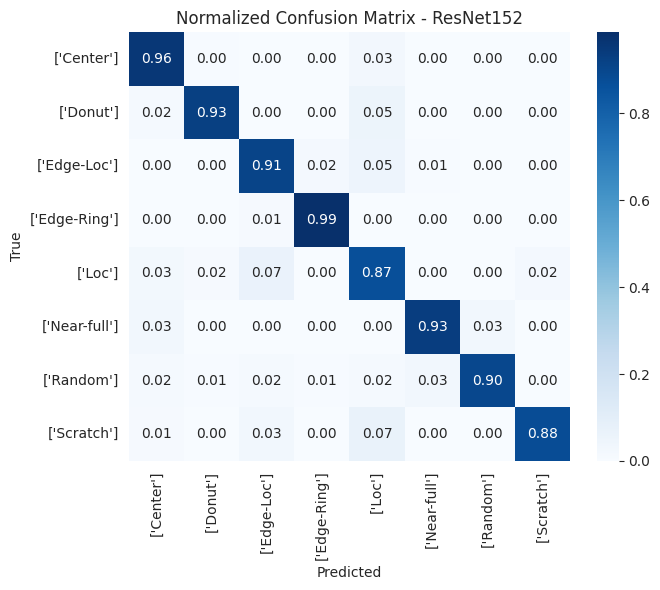


InceptionV3 - Final Evaluation
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step
               precision    recall  f1-score   support

   ['Center']     0.9599    0.9756    0.9677       859
    ['Donut']     0.8512    0.9279    0.8879       111
 ['Edge-Loc']     0.8981    0.9345    0.9160      1038
['Edge-Ring']     0.9845    0.9861    0.9853      1936
      ['Loc']     0.9099    0.8150    0.8599       719
['Near-full']     0.8788    0.9667    0.9206        30
   ['Random']     0.9383    0.8786    0.9075       173
  ['Scratch']     0.8730    0.9244    0.8980       238

     accuracy                         0.9418      5104
    macro avg     0.9117    0.9261    0.9178      5104
 weighted avg     0.9420    0.9418    0.9413      5104

Macro F1:    0.9178
Weighted F1: 0.9413


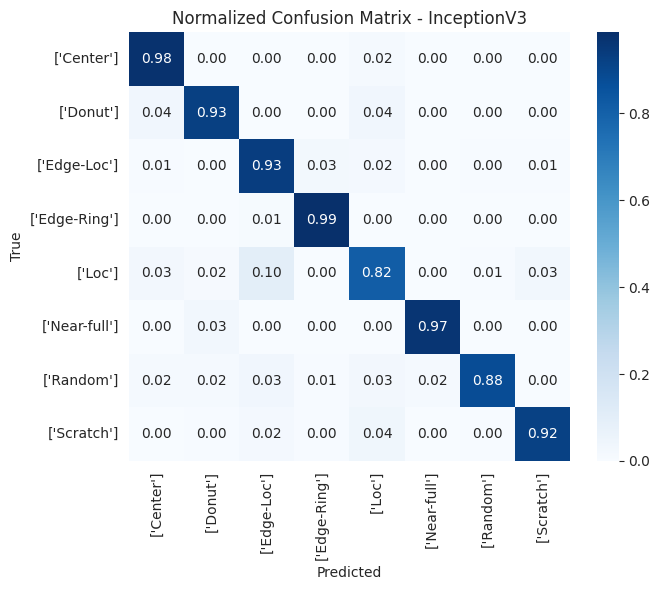


DenseNet121 - Final Evaluation
319/319 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step
               precision    recall  f1-score   support

   ['Center']     0.9659    0.9558    0.9608       859
    ['Donut']     0.8559    0.8559    0.8559       111
 ['Edge-Loc']     0.8918    0.9451    0.9177      1038
['Edge-Ring']     0.9870    0.9824    0.9847      1936
      ['Loc']     0.8891    0.8359    0.8616       719
['Near-full']     0.9000    0.9000    0.9000        30
   ['Random']     0.8883    0.9191    0.9034       173
  ['Scratch']     0.9177    0.8908    0.9041       238

     accuracy                         0.9400      5104
    macro avg     0.9120    0.9106    0.9110      5104
 weighted avg     0.9404    0.9400    0.9399      5104

Macro F1:    0.9110
Weighted F1: 0.9399


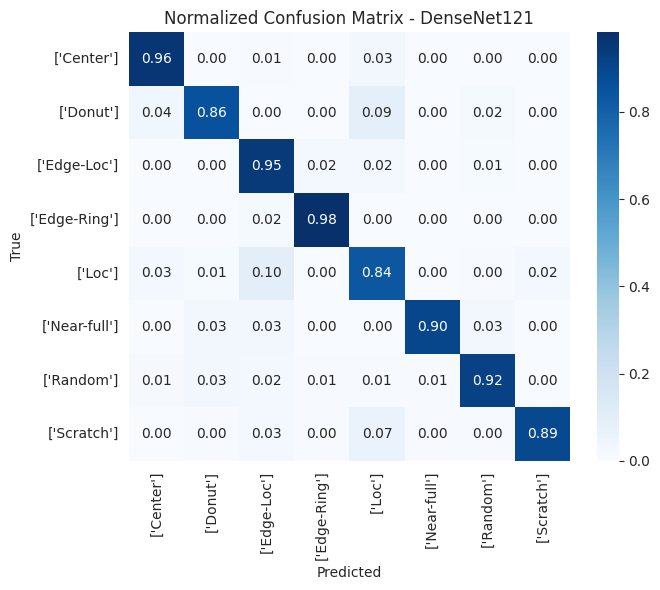


MobileNetV2 - Final Evaluation
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
               precision    recall  f1-score   support

   ['Center']     0.9336    0.9814    0.9569       859
    ['Donut']     0.8362    0.8739    0.8546       111
 ['Edge-Loc']     0.8803    0.9210    0.9002      1038
['Edge-Ring']     0.9895    0.9726    0.9810      1936
      ['Loc']     0.8737    0.8081    0.8396       719
['Near-full']     0.7879    0.8667    0.8254        30
   ['Random']     0.9064    0.8960    0.9012       173
  ['Scratch']     0.9163    0.8739    0.8946       238

     accuracy                         0.9304      5104
    macro avg     0.8905    0.8992    0.8942      5104
 weighted avg     0.9308    0.9304    0.9302      5104

Macro F1:    0.8942
Weighted F1: 0.9302


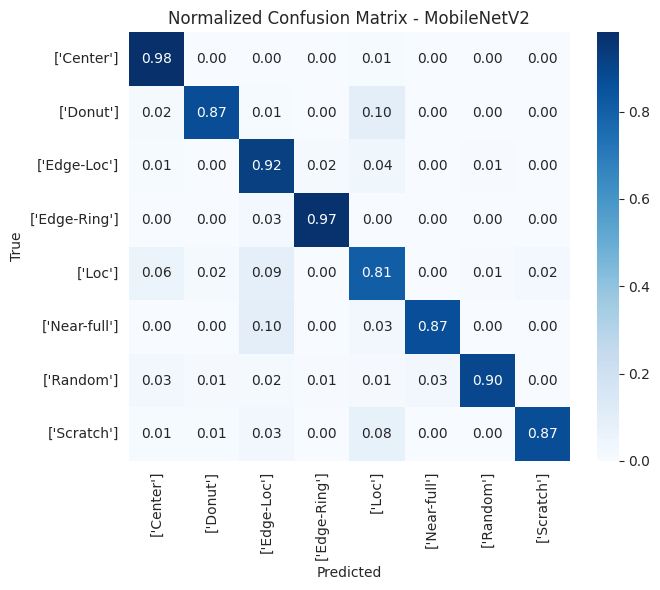


F1 Score Comparison:
      Model  Macro F1  Weighted F1
InceptionV3  0.917846     0.941349
  ResNet152  0.905257     0.940633
DenseNet121  0.911021     0.939907
MobileNetV2  0.894181     0.930182
 Custom CNN  0.890372     0.924644


In [34]:
final_results = []
all_preds = {}

for name, model in models_dict.items():
    y_t, y_p, y_prob, mf1, wf1 = evaluate_model_final(model, name, test_gen)
    all_preds[name] = (y_t, y_p, y_prob)
    final_results.append([name, mf1, wf1])

f1_df = pd.DataFrame(final_results, columns=["Model", "Macro F1", "Weighted F1"])
f1_df = f1_df.sort_values("Weighted F1", ascending=False)

print("\nF1 Score Comparison:")
print(f1_df.to_string(index=False))

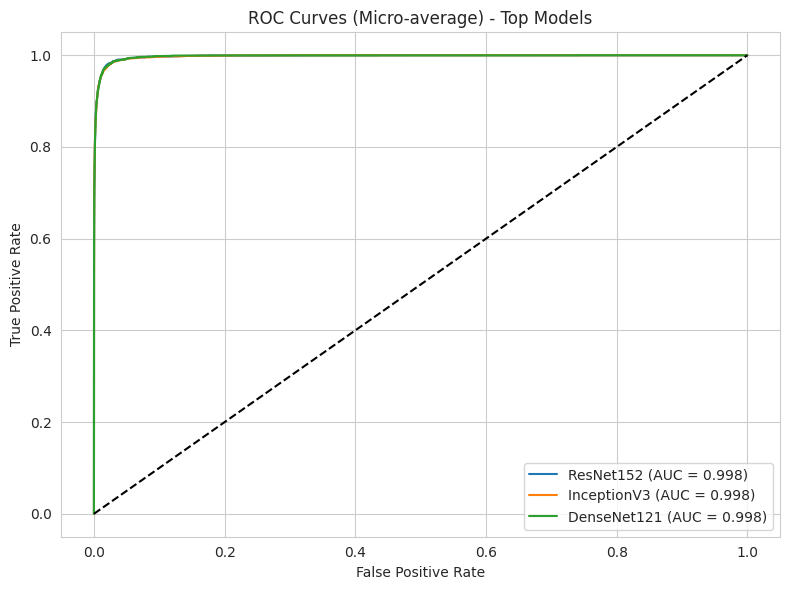

In [35]:
plt.figure(figsize=(8,6))

for name in ["ResNet152", "InceptionV3", "DenseNet121"]:
    y_true, _, y_prob = all_preds[name]
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Micro-average) - Top Models")
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
histories = {
    "Custom CNN": history_custom,
    "ResNet152": history_resnet,
    "InceptionV3": history_inception,
    "DenseNet121": history_densenet,
    "MobileNetV2": history_mobilenet
}

times = {
    "Custom CNN": time_custom/60,
    "ResNet152": time_resnet/60,
    "InceptionV3": time_inception/60,
    "DenseNet121": time_densenet/60,
    "MobileNetV2": time_mobilenet/60
}

accs = {
    "Custom CNN": acc_custom,
    "ResNet152": acc_resnet,
    "InceptionV3": acc_inception,
    "DenseNet121": acc_densenet,
    "MobileNetV2": acc_mobilenet
}

In [37]:
def measure_inference_time(model, gen, steps=20):
    import time
    t0 = time.time()
    for i in range(steps):
        X_batch, _ = gen[i]
        _ = model.predict(X_batch, verbose=0)
    t1 = time.time()
    imgs = steps * gen.batch_size
    return (t1 - t0) / imgs * 1000  

In [39]:
comparison = []

for name, model in models_dict.items():
    total_params = model.count_params()
    trainable_params = np.sum([tf.size(w).numpy() for w in model.trainable_weights])
    non_trainable = total_params - trainable_params
    size_mb = total_params * 4 / (1024**2)

    hist = histories[name]
    best_epoch = np.argmax(hist.history['val_accuracy'])

    train_acc = hist.history['accuracy'][best_epoch]
    val_acc = hist.history['val_accuracy'][best_epoch]
    gap = train_acc - val_acc

    mf1 = f1_df[f1_df['Model'] == name]['Macro F1'].values[0]
    wf1 = f1_df[f1_df['Model'] == name]['Weighted F1'].values[0]

    inf_time = measure_inference_time(model, test_gen, steps=10)

    comparison.append([
        name,
        total_params,
        trainable_params,
        non_trainable,
        size_mb,
        accs[name]*100,
        mf1,
        wf1,
        times[name],
        gap,
        inf_time
    ])

cols = [
    "Model", "Total Params", "Trainable Params", "Non-trainable Params",
    "Model Size (MB)", "Test Accuracy (%)",
    "Macro F1", "Weighted F1",
    "Training Time (min)", "Gen Gap",
    "Inference Time (ms/img)"
]

comp_df = pd.DataFrame(comparison, columns=cols)
comp_df = comp_df.sort_values("Weighted F1", ascending=False)

print("\nFULL MODEL COMPARISON")
print("="*90)
print(comp_df.to_string(index=False))


FULL MODEL COMPARISON
      Model  Total Params  Trainable Params  Non-trainable Params  Model Size (MB)  Test Accuracy (%)  Macro F1  Weighted F1  Training Time (min)   Gen Gap  Inference Time (ms/img)
InceptionV3      22858024          22822568                 35456        87.196442          93.750000  0.917846     0.941349            49.872684  0.016113                 6.904830
  ResNet152      59426184          59273736                152448       226.692902          94.239813  0.905257     0.940633           135.888166  0.032963                13.211916
DenseNet121       7568456           7483784                 84672        28.871368          94.063479  0.911021     0.939907            60.721362  0.012390                 7.573165
MobileNetV2       2920008           2884872                 35136        11.138947          93.456113  0.894181     0.930182            21.601123  0.005581                 6.042176
 Custom CNN       1444136           1440680                  3456       

In [41]:
pretty_df = comp_df.copy()

pretty_df["Model Size (MB)"] = pretty_df["Model Size (MB)"].map(lambda x: f"{x:.2f}")
pretty_df["Test Accuracy (%)"] = pretty_df["Test Accuracy (%)"].map(lambda x: f"{x:.2f}")
pretty_df["Macro F1"] = pretty_df["Macro F1"].map(lambda x: f"{x:.4f}")
pretty_df["Weighted F1"] = pretty_df["Weighted F1"].map(lambda x: f"{x:.4f}")
pretty_df["Training Time (min)"] = pretty_df["Training Time (min)"].map(lambda x: f"{x:.1f}")
pretty_df["Gen Gap"] = pretty_df["Gen Gap"].map(lambda x: f"{x:.4f}")
pretty_df["Inference Time (ms/img)"] = pretty_df["Inference Time (ms/img)"].map(lambda x: f"{x:.2f}")

pretty_df["Total Params"] = pretty_df["Total Params"].map(lambda x: f"{x:,}")
pretty_df["Trainable Params"] = pretty_df["Trainable Params"].map(lambda x: f"{x:,}")
pretty_df["Non-trainable Params"] = pretty_df["Non-trainable Params"].map(lambda x: f"{x:,}")

display(pretty_df)

,Model,Total Params,Trainable Params,Non-trainable Params,Model Size (MB),Test Accuracy (%),Macro F1,Weighted F1,Training Time (min),Gen Gap,Inference Time (ms/img)
2,InceptionV3,"22,858,024","22,822,568","35,456",87.20,93.75,0.9178,0.9413,49.9,0.0161,6.90
1,ResNet152,"59,426,184","59,273,736","152,448",226.69,94.24,0.9053,0.9406,135.9,0.0330,13.21
3,DenseNet121,"7,568,456","7,483,784","84,672",28.87,94.06,0.9110,0.9399,60.7,0.0124,7.57
4,MobileNetV2,"2,920,008","2,884,872","35,136",11.14,93.46,0.8942,0.9302,21.6,0.0056,6.04
0,Custom CNN,"1,444,136","1,440,680","3,456",5.51,92.54,0.8904,0.9246,30.1,-0.0126,7.25


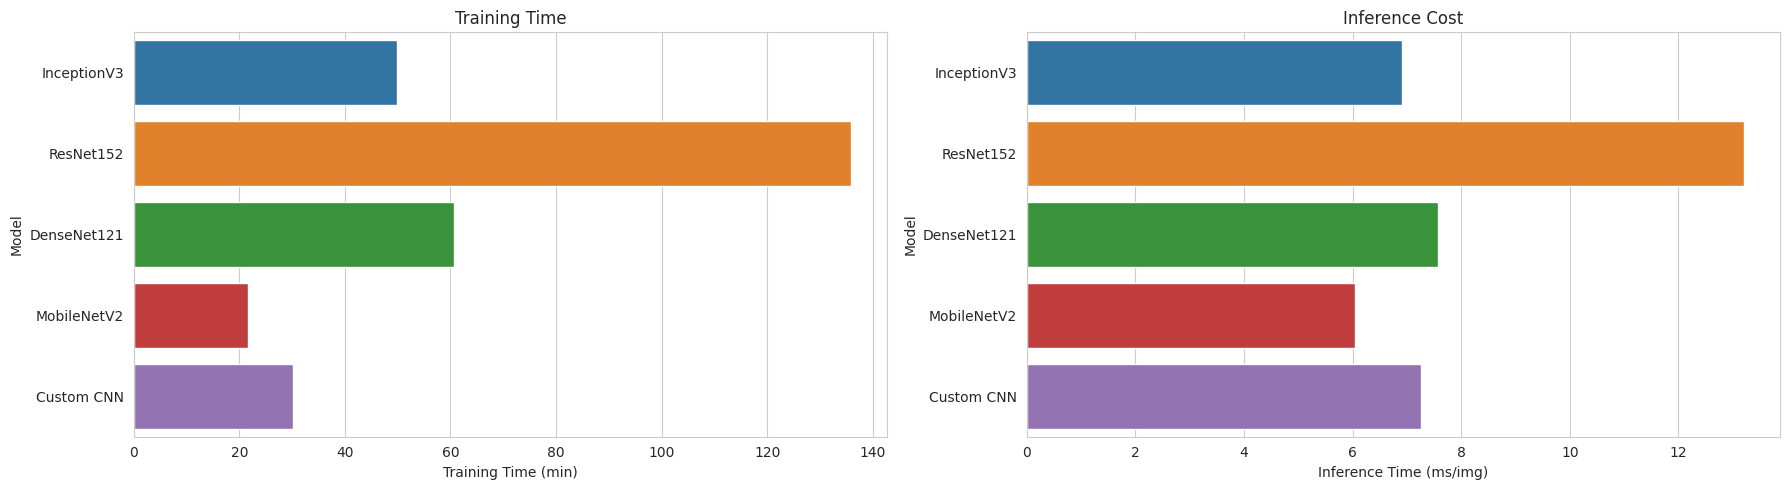

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))

sns.barplot(data=comp_df, x="Training Time (min)", y="Model", ax=ax[0])
ax[0].set_title("Training Time")

sns.barplot(data=comp_df, x="Inference Time (ms/img)", y="Model", ax=ax[1])
ax[1].set_title("Inference Cost")

plt.tight_layout()
plt.show()